# Auto loop annotaion

In [27]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, gridspec, ticker
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import EngFormatter
import matplotlib.patheffects as pe
import numpy as np
import pandas as pd
import seaborn as sns
import bioframe as bf
import cooler
import cooltools
from cooltools.sandbox.expected_smoothing import log_smooth
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, f1_score, accuracy_score, precision_score, recall_score
import utils
import warnings
warnings.filterwarnings("ignore")
import ast
import datetime


# Matplotlib settings
mpl.rc('lines', linewidth=0.4)
mpl.rc('font', family='Helvetica', size=8)
mpl.rc('axes', labelsize=8, titlesize=8, linewidth=0.4)
mpl.rc('legend', fontsize=8)
mpl.rc('xtick', labelsize=6)
mpl.rc('xtick.major', width=0.4, size=2)
mpl.rc('xtick.minor', width=0.4, size=1)
mpl.rc('ytick', labelsize=6)
mpl.rc('ytick.major', width=0.4, size=2)
mpl.rc('ytick.minor', width=0.4, size=1)

colors = {'NeuN+': sns.color_palette()[4], 
          'NeuN-': sns.color_palette()[1]}

def calculate_size(row):
    if row['strand1'] == '+':
        if row['strand2'] == '+':
            return row['start_promoter2'] - row['start_promoter1']
        else:
            return row['end_promoter2'] - row['start_promoter1']
    else:
        if row['strand2'] == '+':
            return row['start_promoter2'] - row['end_promoter1']
        else:
            return row['end_promoter2'] - row['end_promoter1']

def regs_to_bins(regs_df, binsize, mode='middle', return_index=True):
    """
    Assign bins to each genomic region
    
    Parameters
    ----------
    regs_df : pd.DataFrame
        Dataframe with genomic regions. 
        Required columns are: 'chrom', 'start', 'end'
    binsize : int
    mode : 'middle' or 'all'
        If 'middle': for each region, get a bin that overlap the middle of the region.
        If 'all': for each region, get all bins that overlap this region and write to separate rows 
    return_index : bool
        If True and mode='all', return index of input dataframe.
        
    Returns
    -------
    bins_df : pd.DataFrame
        Dataframe with bin coordinates written in
        'chrom', 'start', 'end' columns
    """
    
    if mode == 'middle':
        bins_df = regs_df.copy(deep=True)
        bins_df.loc[:, 'start'] = (bins_df['start'] + bins_df['end']) / 2 \
        - ((bins_df['start'] + bins_df['end']) / 2) % binsize
        bins_df.loc[:, 'end'] = bins_df['start'] + binsize
        bins_df.loc[:, ['start', 'end']] = bins_df.loc[:, ['start', 'end']].astype(int)
        
    elif mode == 'all':
        regs_cp = regs_df.copy(deep=True)
        regs_cp.loc[:, 'first_bin_start'] = regs_cp['start'] - (regs_cp['start'] % binsize)
        regs_cp.loc[:, 'last_bin_end'] = regs_cp['end'] - 1 - (regs_cp['end'] - 1) % binsize + binsize
        regs_cp.loc[:, 'nbins'] = (regs_cp['last_bin_end'] - regs_cp['first_bin_start']) // binsize
        regs_cp.loc[:, 'idx'] = regs_cp.index
        
        all_bins = np.empty((regs_cp['nbins'].sum(), 3), dtype=int)
        i = 0
        for reg_id in range(regs_cp.shape[0]):
            n, start, end, idx = regs_cp.loc[
                reg_id, ['nbins', 'first_bin_start', 'last_bin_end', 'idx']]
            all_bins[i:i+n, 0] = np.arange(start, end, binsize)
            all_bins[i:i+n, 1] = np.arange(start+binsize, end+binsize, binsize)
            all_bins[i:i+n, 2] = np.tile(idx, n)
            i+=n
            
        bins_df = pd.DataFrame(data=all_bins, columns=['start', 'end', 'idx'])
        regs_cp_drop_cols = ['start', 'end', 'first_bin_start', 'last_bin_end', 'nbins']
        bins_df = bins_df.merge(regs_cp.drop(columns=regs_cp_drop_cols), on='idx', how='left')
        bins_df.insert(0, 'chrom', bins_df.pop('chrom'))
        
        if not return_index:
            bins_df = bins_df.drop(columns='idx')
        else:
            bins_df.insert(bins_df.shape[1]-1, 'idx', bins_df.pop('idx'))
        
    else:
        raise ValueError()
        
    return bins_df

In [3]:
today = datetime.date.today()
date = f'{today.strftime('%d')}.{today.strftime('%m')}.{today.strftime('%Y')}'
date

'04.07.2025'

In [4]:
# Read Hi-C data for excitatory and inhibitory neurons

clr_path = {
    'EN': '/tank/projects/tian2023/mcools_fixed/MTG_LEC_A46_FI_M1C_V1C_Pir_A24.EN.29_42_58_years.17356_cells.1kb.mcool',
    'IN': '/tank/projects/tian2023/mcools_fixed/MTG_LEC_A46_FI_M1C_V1C_Pir_A24.IN.29_42_58_years.17356_cells.1kb.mcool',     
}
cts = list(clr_path.keys()) # cell types

res = 100_000 # Hi-C resolution
clrs = {ct: cooler.Cooler(clr_path[ct] + f'::resolutions/{res}') 
        for ct in cts}

# Long-range intersections

In [5]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bf.fetch_chromsizes('hg38')
hg38_chromsizes_view = pd.DataFrame(data={'chrom': hg38_chromsizes.index, 
                                          'start': 0*len(hg38_chromsizes),
                                          'end': hg38_chromsizes.values,
                                          'name': hg38_chromsizes.index})

In [6]:
gaba_chip = pd.read_csv('/tank/projects/schizophrenia_2021/asoldatenkova/peaks_verified_kozlenkov/chip_gaba_neurons_s_3.38_l_1500.csv')
glu_chip = pd.read_csv('/tank/projects/schizophrenia_2021/asoldatenkova/peaks_verified_kozlenkov/chip_glu_neurons_s_3.38_l_1500.csv')

gaba_chip = gaba_chip.rename(columns={"gene.name": "genes"})
gaba_chip = regs_to_bins(gaba_chip, 10000, mode='middle', return_index=True)
gaba_hand = gaba_chip.merge(gaba_chip, how='cross', suffixes=('1', '2'))
gaba_hand = gaba_hand.loc[lambda _df: _df["chrom1"] == _df["chrom2"]]
gaba_hand['size'] = gaba_hand.apply(calculate_size, axis=1)
gaba_hand = gaba_hand.loc[lambda _df: _df["size"] >= int(3e6)]
gaba_hand = gaba_hand.loc[lambda _df: _df["size"] < int(1e10)]
gaba_hand = gaba_hand.drop('size', axis=1)
gaba_hand['type'] = 'IN'


glu_chip = glu_chip.rename(columns={"gene.name": "genes"})
glu_chip = regs_to_bins(glu_chip, 10000, mode='middle', return_index=True)
glu_hand = glu_chip.merge(glu_chip, how='cross', suffixes=('1', '2'))
glu_hand = glu_hand.loc[lambda _df: _df["chrom1"] == _df["chrom2"]]
glu_hand['size'] = glu_hand.apply(calculate_size, axis=1)
glu_hand = glu_hand.loc[lambda _df: _df["size"] >= int(3e6)]
glu_hand = glu_hand.loc[lambda _df: _df["size"] < int(1e10)]
glu_hand = glu_hand.drop('size', axis=1)
glu_hand['type'] = 'EN'

pair_sites = pd.concat([gaba_hand, glu_hand], ).reset_index(drop=True)

columns_for_dup = ['chrom1', 'start1', 'end1', 'genes1', 'strand1', 'chrom2', 'start2', 'end2', 'genes2', 'strand2', 'length1', 'length2']
pair_sites['duplicate_count'] = pair_sites.duplicated(subset = columns_for_dup, keep=False).astype(int)
pair_sites = pair_sites.drop_duplicates(subset = columns_for_dup, keep='first')
pair_sites['type'] = pair_sites.apply(lambda row: 'both' if row['duplicate_count'] == 1 and row['type'] in ['IN', 'EN'] else row['type'], axis=1)
pair_sites = pair_sites.drop(columns='duplicate_count')
pair_sites = pair_sites.reset_index(drop=True)
pair_sites.head()

,chrom1,start1,end1,peak1,score1,signal.value1,pvalue1,qvalue1,genes1,gene.id1,...,pvalue2,qvalue2,genes2,gene.id2,strand2,chrom_promoter2,start_promoter2,end_promoter2,length2,type
0,chr1,9990000,10000000,GABA_REP1_peak_266,21,3.59849,4.42713,2.12352,RBP7,ENSG00000162444,...,4.49150,2.19570,HNRNPCL2,ENSG00000275774,-,chr1,13114854,13118855,3423,IN
1,chr1,9990000,10000000,GABA_REP1_peak_266,21,3.59849,4.42713,2.12352,RBP7,ENSG00000162444,...,5.32864,2.79277,PRAMEF15,ENSG00000204501,+,chr1,13313579,13317580,4001,IN
2,chr1,9990000,10000000,GABA_REP1_peak_266,21,3.59849,4.42713,2.12352,RBP7,ENSG00000162444,...,5.18872,2.70291,PAX7,ENSG00000009709,+,chr1,18628844,18632845,3595,IN
3,chr1,9990000,10000000,GABA_REP1_peak_266,21,3.59849,4.42713,2.12352,RBP7,ENSG00000162444,...,4.27779,2.02140,SERINC2,ENSG00000168528,+,chr1,31407563,31411564,3665,IN
4,chr1,9990000,10000000,GABA_REP1_peak_266,21,3.59849,4.42713,2.12352,RBP7,ENSG00000162444,...,4.21432,1.94847,ZBTB8A,ENSG00000160062,+,chr1,32537425,32541426,2776,IN


In [7]:
res = 100_000 # Hi-C resolution
clrs = {ct: cooler.Cooler(clr_path[ct] + f'::resolutions/{res}') 
        for ct in cts}
cvd = {}

for ct in cts:
    print(ct)
    cvd[ct] = cooltools.expected_cis(
        clrs[ct],
        view_df=hg38_chromsizes_view,
        smooth=False,
        nproc=6,
    )

# Get snips
stack = {}
flank = 10*res

for ct in cts:
    print(ct)
    stack[ct] = cooltools.pileup(
        clrs[ct], 
        pair_sites, 
        view_df=hg38_chromsizes_view, 
        expected_df=cvd[ct], 
        flank=flank,
    )

# Add pileup values
for ct in cts:
    pair_sites[f'vals_100k_{ct}'] = stack[ct].tolist()

EN
IN
EN
IN


In [8]:
pair_sites.to_csv(f'pred_neurons/pair_sites_chip_seq_both_neuron_types_vals_{today.strftime('%d')}.{today.strftime('%m')}.csv', index=False)

In [9]:
pair_sites.shape

(19598, 33)

### train/test dataset

In [10]:
pair_sites_v = pd.read_csv('/tank/projects/schizophrenia_2021/results/2024.04.05/part2.train_set.150_snips.MTG_LEC_A46_FI_M1C_V1C_Pir_A24.17356_cells.tsv', 
                           sep='\t').rename(columns={'dot_in_EN?':'EN_polycomb_dot_ilya', 'dot_in_IN?':'IN_polycomb_dot_ilya'})

resultions = [100_000]
for res in resultions:
    print(res)
    clrs = {ct: cooler.Cooler(clr_path[ct] + f'::resolutions/{res}') for ct in cts}
    cvd = {}
    for ct in cts:
        print(ct)
        cvd[ct] = cooltools.expected_cis(
            clrs[ct], view_df=hg38_chromsizes_view,smooth=False, nproc=6,
        )

    # Get snips
    stack = {}
    flank = 10*res

    for ct in cts:
        print(ct)
        stack[ct] = cooltools.pileup(
            clrs[ct], pair_sites_v, view_df=hg38_chromsizes_view, 
            expected_df=cvd[ct], flank=flank,
        )

    # Add pileup values
    ak = int(res/1000)
    for ct in cts:
        pair_sites_v[f'vals_{ak}k_{ct}'] = stack[ct].tolist()

pair_sites_v.head()

100000
EN
IN
EN
IN


,Unnamed: 0,chrom1,start1,end1,chrom2,start2,end2,EN_polycomb_dot_ilya,IN_polycomb_dot_ilya,vals_100k_EN,vals_100k_IN
0,0,chr5,141120000,141130000,chr5,159080000,159090000,False,False,"[[0.6477183294592803, 0.589523845021345, 0.734...","[[0.32149830268117213, 0.3858459046522204, 0.4..."
1,1,chr10,23180000,23190000,chr10,101230000,101240000,False,True,"[[0.7347067772222984, 1.0381586341750488, 0.86...","[[0.6733544124842837, 1.2533863607848297, 1.26..."
2,2,chr10,23190000,23200000,chr10,99530000,99540000,True,True,"[[1.3308945704290343, 1.7712373770159153, 1.77...","[[1.9312437024237035, 1.985248459378072, 1.469..."
3,3,chr8,11670000,11680000,chr8,66960000,66970000,False,False,"[[1.0087799621286133, 1.1216952283292452, 0.92...","[[0.948358604972979, 1.4538262203434686, 1.438..."
4,4,chr19,41080000,41090000,chr19,53250000,53260000,False,False,"[[1.905778507808567, 2.232135063435673, 1.8963...","[[3.541610009471702, 3.5774232157181034, 3.614..."


In [11]:
pair_sites_v.to_csv(f'pred_neurons/train_set.150_chip_snips.MTG_LEC_A46_FI_M1C_V1C_Pir_A24.17356_cells.{today.strftime('%d')}.{today.strftime('%m')}.csv', index=False)

# Regression

In [12]:
list_with_identification = ['Accuracy', 'Precision', 'Recall', 'f1_score', 'AUC ROC score', 'Specificity']

def fill_none_with_zero(nested_list):
    return [[0 if x is None else x for x in inner_list] for inner_list in nested_list]

def has_too_many_nan_lines(matrix, number):
    matrix = np.array(matrix, dtype=object) 
    matrix = np.where(matrix == None, np.nan, matrix)
    matrix = matrix.astype(float) 
    nan_rows = np.sum(np.all(np.isnan(matrix), axis=1)) 
    nan_cols = np.sum(np.all(np.isnan(matrix), axis=0))
    return nan_rows >= number or nan_cols >= number

def extract_single_value(cell):
    return cell[0]

def extract_and_mean(nested_list, start_row, start_col, size=3):
    square = [row[start_col:start_col+size] for row in nested_list[start_row:start_row+size]]
    flat_list = [item if item is not None else 0 for sublist in square for item in sublist]
    return np.mean(flat_list)

def p2rl(nested_list):
    central = nested_list[10][10]
    square = [row[:10] for row in nested_list[:10]]
    left_corner = [item if item is not None else 0 for sublist in square for item in sublist]
    left_corner_mean = np.mean(left_corner)
    if central != None and left_corner_mean != 0:
        p2rl = central/left_corner_mean
        return p2rl
    return 0

def frame_and_mean(nested_list, frame):
    indices = []
    for i in range(frame):
        for j in range(frame):
            if i == 0 or i == frame - 1 or j == 0 or j == frame - 1:
                indices.append((i, j))
                
    frame_values = []
    default_start = 8
    default_frame = 5
    start = default_start - int((frame - default_frame)/2)
         
    for i, j in indices:
        value = nested_list[start + i][start + j]
        frame_values.append(value if value is not None else 0)
    return np.mean(frame_values)

def area(nested_list, size):
    '''
    size -- central part, type length of 1 side
    return total sum
    '''
    start_row = int((21-size)/2)
    start_col = int((21-size)/2)

    square = [row[start_col:start_col+size] for row in nested_list[start_row:start_row+size]]
    flat_list = [item if item is not None else 0 for sublist in square for item in sublist]
    return np.sum(flat_list)

def central_vs_frame(central_element, frame_mean):
    if frame_mean != 0 and central_element != 0 and isinstance(central_element / frame_mean, float):
        return central_element / frame_mean
    return 0

def p24c(nested_list, i, j):
    central = nested_list[10][10]
    square_1 = [row[:i] for row in nested_list[:i]]   # Top-left
    square_2 = [row[j:] for row in nested_list[:i]]   # Top-right
    square_3 = [row[:i] for row in nested_list[j:]]   # Bottom-left
    square_4 = [row[j:] for row in nested_list[j:]]   # Bottom-righ
    
    items = [item if item is not None else 0 for square in [square_1, square_2, square_3, square_4] for sublist in square for item in sublist]

    mean_value = np.mean(items)
    if central != None and mean_value != 0:
        p24c = central/mean_value
        return p24c
    return 0

def replace_none_with_0(value):
    """Recursively replace None with np.nan in nested lists or arrays."""
    if isinstance(value, list):
        return [replace_none_with_0(v) for v in value]
    elif isinstance(value, np.ndarray):
        return np.array([replace_none_with_0(v) for v in value])
    elif value is None:
        return 0
    return value

def feature_creation(dataset, type, resolution):
    '''
    dataset; 
    type: currently EN or IN; 
    resolution: 100k, 50k, 20k, 10k
    '''
    dataset[f'vals_{resolution}_{type}'] = dataset[f'vals_{resolution}_{type}'].apply(lambda x: ast.literal_eval(x.replace('nan', 'None')))
    dataset[f'vals_{resolution}_{type}_0'] = dataset[f'vals_{resolution}_{type}'].apply(replace_none_with_0)
    dataset[f'p2rl_{resolution}_{type}'] = dataset[f'vals_{resolution}_{type}'].apply( lambda x: p2rl(x))
    dataset[f'p24c_10_{resolution}_{type}'] = dataset[f'vals_{resolution}_{type}'].apply( lambda x: p24c(x, 10, 11))
    dataset[f'p24c_9_{resolution}_{type}']  = dataset[f'vals_{resolution}_{type}'].apply( lambda x: p24c(x,  9, 12))
    dataset[f'central_element_{resolution}_{type}'] = dataset[f'vals_{resolution}_{type}'].apply( lambda x: x[10][10]).fillna(value = 0)
    dataset[f'central_mean_{resolution}_{type}'] = dataset[f'vals_{resolution}_{type}'].apply( lambda x: extract_and_mean(x,9,9))

    list_with_numbers = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
    for i in list_with_numbers:
        dataset[f'central_area_sum_{i}_{resolution}_{type}'] = dataset[f'vals_{resolution}_{type}'].apply(lambda x: area(x, i))
        if i != 3:
            dataset[f'frame_{i}_{resolution}_{type}'] = dataset[f'vals_{resolution}_{type}'].apply(lambda x: frame_and_mean(x, i))
            dataset[f'central_{i}_{resolution}_{type}'] = dataset.apply(lambda x: central_vs_frame(x[f'central_element_{resolution}_{type}'], x[f'frame_{i}_{resolution}_{type}']), axis=1)
    
    return dataset

In [13]:
def polycomb_reg_logistic(reg, X_train, Y_train, X_test, Y_test, target_column, plot_title, colour, resolution):
    reg.fit(X_train, Y_train)
    y_pred_test_binary = reg.predict(X_test)
    y_pred_test = reg.predict_proba(X_test)

    tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_test_binary).ravel()
    preds = y_pred_test[:,1]
    fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    print(classification_report(Y_test, y_pred_test_binary))
    new_list = []
    new_list.extend((
        accuracy_score(Y_test, y_pred_test_binary),        #ACC
        precision_score(Y_test, y_pred_test_binary),       #Precision
        recall_score(Y_test, y_pred_test_binary),          #Recall
        f1_score(Y_test, y_pred_test_binary),              #f1_score
        roc_auc_score(Y_test, y_pred_test[:, 1]),          #AUC ROC score, preds
        tn/(tn+fp) ,                                       #Specificity
    ))
    
    Y_test['pred'] = y_pred_test[:,1].tolist()
    return reg, Y_test, new_list, fpr, tpr, roc_auc

reg_logistic = LogisticRegression(penalty='l2', tol=0.0001, C=0.5)

## Datasets

### Create and save datasets

In [14]:
pair_sites = pd.read_csv('pred_neurons/pair_sites_chip_seq_both_neuron_types_vals_04.07.csv')

pair_sites['higlass'] = pair_sites.apply(lambda row: f"{row['chrom1']}:{row['start1']}-{row['end1']} & {row['chrom2']}:{row['start2']}-{row['end2']}", axis=1)
pair_sites = pair_sites.reset_index(drop=True)

pair_sites_EN = pair_sites[['higlass', 'chrom1','start1', 'end1','chrom2','start2', 'end2', 'genes1', 'genes2', 'gene.id1', 'gene.id2', 'score1', 
                            'signal.value1', 'pvalue1', 'qvalue1', 'strand1', 'chrom_promoter1', 'start_promoter1', 'end_promoter1', 
                            'length1',  'score2', 'signal.value2', 'pvalue2', 'qvalue2', 'strand2', 'chrom_promoter2', 'start_promoter2', 
                            'end_promoter2', 'length2', 'vals_100k_EN', 'type']]
pair_sites_EN = pair_sites_EN.loc[pair_sites_EN['type'] != 'IN'] 


test = feature_creation(pair_sites_EN, 'EN', '100k')

test.to_csv(f'pred_neurons/preprocessed_datasets/pair_sites_chip_seq_EN_3.38_1500_{today.strftime('%d')}.{today.strftime('%m')}.csv', 
            index=False)

In [15]:
pair_sites = pd.read_csv('pred_neurons/pair_sites_chip_seq_both_neuron_types_vals_04.07.csv')

pair_sites['higlass'] = pair_sites.apply(lambda row: f"{row['chrom1']}:{row['start1']}-{row['end1']} & {row['chrom2']}:{row['start2']}-{row['end2']}", axis=1)
pair_sites = pair_sites.reset_index(drop=True)

pair_sites_IN = pair_sites[['higlass', 'chrom1','start1', 'end1','chrom2','start2', 'end2', 'genes1', 'genes2', 'gene.id1', 'gene.id2', 'score1', 
                            'signal.value1', 'pvalue1', 'qvalue1', 'strand1', 'chrom_promoter1', 'start_promoter1', 'end_promoter1', 
                            'length1',  'score2', 'signal.value2', 'pvalue2', 'qvalue2', 'strand2', 'chrom_promoter2', 'start_promoter2', 
                            'end_promoter2', 'length2', 'vals_100k_IN', 'type']]
pair_sites_IN = pair_sites_IN.loc[pair_sites_IN['type'] != 'EN'] 

test = feature_creation(pair_sites_IN, 'IN', '100k')

test.to_csv(f'pred_neurons/preprocessed_datasets/pair_sites_chip_seq_IN_3.38_1500_{today.strftime('%d')}.{today.strftime('%m')}.csv', 
            index=False)

'''

manual annotated dataset

In [16]:
pair_sites_v = pd.read_csv('pred_neurons/train_set.150_chip_snips.MTG_LEC_A46_FI_M1C_V1C_Pir_A24.17356_cells.04.07.csv')

pair_sites_v['higlass'] = pair_sites_v.apply(lambda row: f"{row['chrom1']}:{row['start1']}-{row['end1']} & {row['chrom2']}:{row['start2']}-{row['end2']}", axis=1)
pair_sites_v = pair_sites_v.reset_index(drop=True)
pair_sites_v[['EN_polycomb_dot_ilya', 'IN_polycomb_dot_ilya']] = pair_sites_v[['EN_polycomb_dot_ilya', 'IN_polycomb_dot_ilya']].astype(int)

pair_sites_v = feature_creation(pair_sites_v, 'EN', '100k')

pair_sites_v = feature_creation(pair_sites_v, 'IN', '100k')

pair_sites_v.to_csv(f'pred_neurons/preprocessed_datasets/train_set.150_chip_snips.MTG_LEC_A46_FI_M1C_V1C_Pir_A24.17356_cells.{today.strftime('%d')}.{today.strftime('%m')}.csv', index=False)

### Use datasets

In [17]:
# validation dataset
pair_sites_v = pd.read_csv('pred_neurons/preprocessed_datasets/train_set.150_chip_snips.MTG_LEC_A46_FI_M1C_V1C_Pir_A24.17356_cells.04.07.csv')

pair_sites_v_1 = pair_sites_v
pair_sites_v_2 = pair_sites_v

# long-range dataset
pair_sites_EN = pd.read_csv('pred_neurons/preprocessed_datasets/pair_sites_chip_seq_EN_3.38_1500_04.07.csv')
pair_sites_IN = pd.read_csv('pred_neurons/preprocessed_datasets/pair_sites_chip_seq_IN_3.38_1500_04.07.csv')

pair_sites_EN_new = pair_sites_EN
pair_sites_IN_new = pair_sites_IN

chr_list_test = ['chr6', 'chr14', 'chr15']
X_EN_test6 = pair_sites_v_1[pair_sites_v_1['chrom1'].isin(chr_list_test)]
y_EN_test6 = pair_sites_v_1[pair_sites_v_1['chrom1'].isin(chr_list_test)][['EN_polycomb_dot_ilya']]
X_EN_train6 = pair_sites_v_1[~pair_sites_v_1['chrom1'].isin(chr_list_test)]
Y_EN_train6 = pair_sites_v_1[~pair_sites_v_1['chrom1'].isin(chr_list_test)][['EN_polycomb_dot_ilya']]

X_IN_test6 = pair_sites_v_2[pair_sites_v_2['chrom1'].isin(chr_list_test)]
y_IN_test6 = pair_sites_v_2[pair_sites_v_2['chrom1'].isin(chr_list_test)][['IN_polycomb_dot_ilya']]
X_IN_train6 = pair_sites_v_2[~pair_sites_v_2['chrom1'].isin(chr_list_test)]
Y_IN_train6 = pair_sites_v_2[~pair_sites_v_2['chrom1'].isin(chr_list_test)][['IN_polycomb_dot_ilya']]

## Model

### logistic Regression 100 kb

In [18]:
### logistic regression
columns = ['central_mean_100k_EN', 
           'central_element_100k_EN',
           'frame_13_100k_EN', 'frame_15_100k_EN','frame_17_100k_EN',
           'central_9_100k_EN', 'central_13_100k_EN', 'central_15_100k_EN', 'central_17_100k_EN',
           #'p2rl_100k_EN',
           'p24c_10_100k_EN',
           #'score_EN', #'qvalue_EN',
           #'central_area_sum_11_100k_EN',
           'central_area_sum_9_100k_EN',
           #'central_area_sum_7_100k_EN',
           'central_area_sum_5_100k_EN',
           'central_area_sum_3_100k_EN',
    ]

X_EN_test6_100k = X_EN_test6[columns]
X_EN_train6_100k = X_EN_train6[columns]
Y_EN_train6_100k = Y_EN_train6['EN_polycomb_dot_ilya']
y_EN_test6_100k  = y_EN_test6['EN_polycomb_dot_ilya']

reg_y, y_test_EN, list_y_100k, fpr_y_100k, tpr_y_100k, roc_auc_y_100k = polycomb_reg_logistic(reg_logistic, X_EN_train6_100k, Y_EN_train6_100k, 
                                                                                              X_EN_test6_100k, y_EN_test6_100k, 
                                         'EN_polycomb_dot_ilya', 'GLUergic neurons', 'g', '100k')

X_pred = pair_sites_EN_new[columns]
y_pred = reg_y.predict_proba(X_pred)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        17
           1       0.85      0.85      0.85        13

    accuracy                           0.87        30
   macro avg       0.86      0.86      0.86        30
weighted avg       0.87      0.87      0.87        30



In [19]:
pair_sites_pred_EN = pair_sites_EN_new.assign(pred=y_pred[:,1])

keep_columns = ['higlass', 'chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'genes1', 'genes2', 'gene.id1', 'gene.id2',
       'score1', 'signal.value1', 'pvalue1', 'qvalue1', 'strand1', 'chrom_promoter1', 'start_promoter1', 'end_promoter1', 'length1',
       'score2', 'signal.value2', 'pvalue2', 'qvalue2', 'strand2', 'chrom_promoter2', 'start_promoter2', 'end_promoter2', 'length2',
       'vals_100k_EN', 'vals_100k_EN_0', 'type', 'pred']

pair_sites_pred_EN = pair_sites_pred_EN[keep_columns]

In [20]:
pair_sites_pred_EN.to_csv(f'pred_neurons/{date}_100k_logistic_chip.EN.csv')

In [21]:
in_columns = ['central_mean_100k_IN', 
              'central_mean_100k_IN', 
              'frame_13_100k_IN', 'frame_15_100k_IN','frame_17_100k_IN',
              'central_9_100k_IN', 'central_13_100k_IN', 'central_15_100k_IN', 'central_17_100k_IN',
              'p2rl_100k_IN',
              #'score_IN', 
              #'qvalue_IN',
              #'central_area_sum_11_IN', 
              'central_area_sum_9_100k_IN',
              #'central_area_sum_7_IN', 
              'central_area_sum_5_100k_IN', 
              'central_area_sum_3_100k_IN',
             ]

X_IN_test6_100k = X_IN_test6[in_columns]
X_IN_train6_100k = X_IN_train6[in_columns] 
Y_IN_train6_100k = Y_IN_train6['IN_polycomb_dot_ilya']
y_IN_test6_100k = y_IN_test6['IN_polycomb_dot_ilya']

reg_i, y_test_IN, list_i_100k, fpr_i_100k, tpr_i_100k, roc_auc_i_100k = polycomb_reg_logistic(reg_logistic, X_IN_train6_100k, Y_IN_train6_100k, 
                                                                                              X_IN_test6_100k, y_IN_test6_100k, 
                                         'IN_polycomb_dot_ilya', 'GABAergic neurons', 'y', '100k')

X_pred_i = pair_sites_IN_new[in_columns]
y_pred_i = reg_i.predict_proba(X_pred_i)

              precision    recall  f1-score   support

           0       0.86      0.75      0.80        16
           1       0.75      0.86      0.80        14

    accuracy                           0.80        30
   macro avg       0.80      0.80      0.80        30
weighted avg       0.81      0.80      0.80        30



In [22]:
pair_sites_pred_IN = pair_sites_IN_new.assign(pred=y_pred_i[:,1])

keep_in_columns = ['higlass', 'chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'genes1', 'genes2', 'gene.id1', 'gene.id2',
       'score1', 'signal.value1', 'pvalue1', 'qvalue1', 'strand1', 'chrom_promoter1', 'start_promoter1', 'end_promoter1', 'length1',
       'score2', 'signal.value2', 'pvalue2', 'qvalue2', 'strand2', 'chrom_promoter2', 'start_promoter2', 'end_promoter2', 'length2',
       'vals_100k_IN', 'vals_100k_IN_0', 'type','pred' ]

pair_sites_pred_IN = pair_sites_pred_IN[keep_in_columns]

In [23]:
pair_sites_pred_IN.to_csv(f'pred_neurons/{date}_100k_logistic_chip.IN.csv')

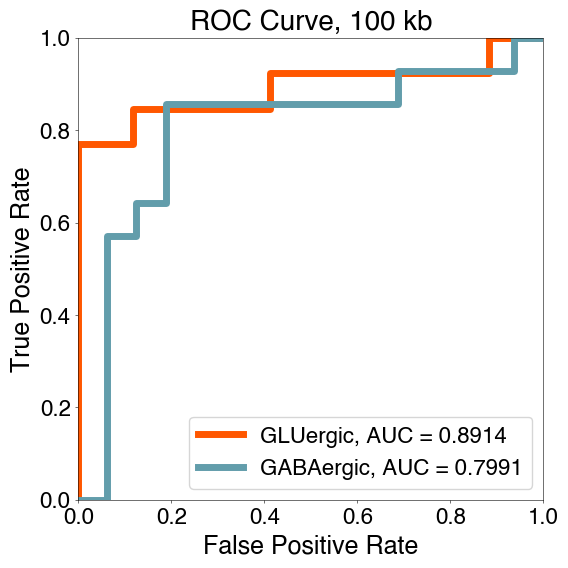

In [24]:
plt.figure(figsize=(6,6))
plt.title(f'ROC Curve, 100 kb', fontsize=20)
plt.plot(fpr_y_100k, tpr_y_100k, '#FF5700',linewidth=5, label = 'GLUergic, AUC = %0.4f' % roc_auc_y_100k)
plt.plot(fpr_i_100k, tpr_i_100k, '#629DAB',linewidth=5, label = 'GABAergic, AUC = %0.4f' % roc_auc_i_100k)
plt.legend(loc = 'lower right', fontsize=16)
#plt.plot([0, 1], [0, 1],'r--')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=18)
plt.savefig(f'pred_neurons/ROC_curve_100k_tian_{date}.png')
plt.show()

In [25]:
metrics_df = pd.DataFrame()
metrics_df['info'] = list_with_identification
metrics_df['GABAergic, 100k'] = list_i_100k
metrics_df['GLUergic, 100k'] =  list_y_100k

metrics_df

,info,"GABAergic, 100k","GLUergic, 100k"
0,Accuracy,0.800000,0.866667
1,Precision,0.750000,0.846154
2,Recall,0.857143,0.846154
3,f1_score,0.800000,0.846154
4,AUC ROC score,0.799107,0.891403
5,Specificity,0.750000,0.882353


## Final filtration from empty columns/rows and threshold selection

In [31]:
resol  = 100
pair_sites_pred_EN[f'vals_{resol}k_EN'] = pair_sites_pred_EN[f'vals_{resol}k_EN'].apply( lambda x: ast.literal_eval(x.replace('nan', 'None')))
pair_sites_pred_IN[f'vals_{resol}k_IN'] = pair_sites_pred_IN[f'vals_{resol}k_IN'].apply( lambda x: ast.literal_eval(x.replace('nan', 'None')))

pair_sites_pred_EN = pair_sites_pred_EN[~pair_sites_pred_EN[f'vals_{resol}k_EN'].apply(lambda x: has_too_many_nan_lines(x, 10))].reset_index(drop=True)
pair_sites_pred_IN = pair_sites_pred_IN[~pair_sites_pred_IN[f'vals_{resol}k_IN'].apply(lambda x: has_too_many_nan_lines(x, 10))].reset_index(drop=True)

pair_sites_pred_EN['promoters'] = pair_sites_pred_EN.apply(lambda row: f"{row['chrom_promoter1']}:{row['start_promoter1']}-{row['end_promoter1']} & {row['chrom_promoter2']}:{row['start_promoter2']}-{row['end_promoter2']}", axis=1)
pair_sites_pred_IN['promoters'] = pair_sites_pred_IN.apply(lambda row: f"{row['chrom_promoter1']}:{row['start_promoter1']}-{row['end_promoter1']} & {row['chrom_promoter2']}:{row['start_promoter2']}-{row['end_promoter2']}", axis=1)

pair_sites_pred_EN.to_csv(f'pred_neurons/EN_tian_{date}.csv', index=False)
pair_sites_pred_IN.to_csv(f'pred_neurons/IN_tian_{date}.csv', index=False)

In [33]:
pair_sites_pred_EN[pair_sites_pred_EN.pred >= 0.65].to_csv(f'pred_neurons/EN_tian_0.65_filter_{date}.csv', index=False)
pair_sites_pred_IN[pair_sites_pred_IN.pred >= 0.8].to_csv(f'pred_neurons/IN_tian_0.8_filter_{date}.csv', index=False)